**Project Overview:**

* Built a **content-based recommendation engine** using unsupervised deep learning.
* Used **autoencoders** to compress movie features (genres, ratings, metadata) into **dense embeddings**.
* Applied **K-Means clustering** to group similar movies.
* Used **cosine similarity** to recommend top N similar movies.
* Visualized embeddings with **t-SNE** and cluster distribution.

**Key Learnings:**

* Autoencoders are powerful for **nonlinear feature extraction**.
* Clustering embeddings helps in **unsupervised grouping**.
* Cosine similarity on embeddings is effective for **content-based recommendations**.
* This approach can be scaled for **large datasets like YouTube or Netflix**.

**Real-World Impact:**

* Enables personalized recommendations without explicit user history.
* Can be extended for **hybrid systems** combining content + collaborative filtering.


- **Dataset:** MovieLens 100k or YouTube Trending Videos (can use metadata: title, category, tags, views, likes).
- **Goal:** Build a **content-based recommendation engine** using autoencoders, embeddings, and clustering.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)       # Set total width of display
pd.set_option('display.max_colwidth', None)  # Show full content of each column


In [3]:
# Load movies metadata (business dataset example)
# dataset : https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
df_movies = pd.read_csv("Data/ml-latest-small/movies.csv")  # Columns: movieId, title, genres
df_ratings = pd.read_csv("Data/ml-latest-small/ratings.csv")  # Columns: userId, movieId, rating

# Merge datasets for content-level features
df = df_ratings.merge(df_movies, on="movieId")
print(f"Dataset shape: {df.shape}")
print(df.head(10))


Dataset shape: (100836, 6)
   userId  movieId  rating  timestamp                        title                                       genres
0       1        1     4.0  964982703             Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy
1       1        3     4.0  964981247      Grumpier Old Men (1995)                               Comedy|Romance
2       1        6     4.0  964982224                  Heat (1995)                        Action|Crime|Thriller
3       1       47     5.0  964983815  Seven (a.k.a. Se7en) (1995)                             Mystery|Thriller
4       1       50     5.0  964982931   Usual Suspects, The (1995)                       Crime|Mystery|Thriller
5       1       70     3.0  964982400   From Dusk Till Dawn (1996)                Action|Comedy|Horror|Thriller
6       1      101     5.0  964980868         Bottle Rocket (1996)               Adventure|Comedy|Crime|Romance
7       1      110     4.0  964982176            Braveheart (1995)           

In [5]:
# One-hot encode genres
df_genres = df['genres'].str.get_dummies('|')
df_combined = pd.concat([df[['movieId']], df_genres], axis=1)
# Aggregate by movie to create content-level feature vector
df_features = df_combined.groupby('movieId').max().reset_index()

# Standardize features for autoencoder input
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_features.drop('movieId', axis=1))

print("Feature matrix shape:", X_scaled.shape)


Feature matrix shape: (9724, 20)


In [6]:
input_dim = X_scaled.shape[1]
encoding_dim = 32  # latent dimension for embeddings

# Encoder
input_layer = Input(shape=(input_dim,), name="input")
encoded = Dense(128, activation='relu', name="encoder_dense1")(input_layer)
encoded = Dense(64, activation='relu', name="encoder_dense2")(encoded)
encoded = Dense(encoding_dim, activation='relu', name="bottleneck")(encoded)

# Decoder
decoded = Dense(64, activation='relu', name="decoder_dense1")(encoded)
decoded = Dense(128, activation='relu', name="decoder_dense2")(decoded)
decoded = Dense(input_dim, activation='sigmoid', name="output")(decoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded, name="Autoencoder")
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
history = autoencoder.fit(X_scaled, X_scaled,
                          epochs=50,
                          batch_size=256,
                          validation_split=0.2,
                          verbose=1)

# Extract embeddings
encoder = Model(input_layer, encoded, name="Encoder")
X_embeddings = encoder.predict(X_scaled)
print("Embeddings shape:", X_embeddings.shape)


Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0621 - val_loss: 1.1748
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8194 - val_loss: 0.9806
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6650 - val_loss: 0.8814
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6044 - val_loss: 0.8444
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5810 - val_loss: 0.8260
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5705 - val_loss: 0.8146
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5642 - val_loss: 0.8099
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5604 - val_loss: 0.8081
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5590 - val_loss: 0.8068
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5583 - val_loss: 0.8065
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5578 - val_loss: 0.8067
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5574 - val_lo

In [7]:
# KMeans clustering to group similar movies
n_clusters = 10  # business decision: can adjust based on platform
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_embeddings)

df_features['Cluster'] = clusters
df = df.merge(df_features[['movieId', 'Cluster']], on='movieId')
print(df[['title', 'genres', 'Cluster']].head(10))


                         title                                       genres  Cluster
0             Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy        6
1      Grumpier Old Men (1995)                               Comedy|Romance        7
2                  Heat (1995)                        Action|Crime|Thriller        1
3  Seven (a.k.a. Se7en) (1995)                             Mystery|Thriller        8
4   Usual Suspects, The (1995)                       Crime|Mystery|Thriller        8
5   From Dusk Till Dawn (1996)                Action|Comedy|Horror|Thriller        3
6         Bottle Rocket (1996)               Adventure|Comedy|Crime|Romance        7
7            Braveheart (1995)                             Action|Drama|War        1
8               Rob Roy (1995)                     Action|Drama|Romance|War        0
9        Canadian Bacon (1995)                                   Comedy|War        7


In [8]:
# Compute cosine similarity between movies in embedding space
similarity_matrix = cosine_similarity(X_embeddings)

def recommend(movie_id, top_n=5):
    """Recommend top N similar movies based on embeddings"""
    idx = df_features[df_features['movieId'] == movie_id].index[0]
    sim_scores = list(enumerate(similarity_matrix[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]
    recommended_indices = [i[0] for i in sim_scores]
    recommended_movies = df_features.iloc[recommended_indices].merge(df_movies, on='movieId')
    return recommended_movies[['title', 'Cluster']]

# Example: Recommend for first movie
print(recommend(df_features['movieId'].iloc[0], top_n=5))


                                            title  Cluster
0                                     Antz (1998)        6
1                              Toy Story 2 (1999)        6
2  Adventures of Rocky and Bullwinkle, The (2000)        6
3                Emperor's New Groove, The (2000)        6
4                           Monsters, Inc. (2001)        6


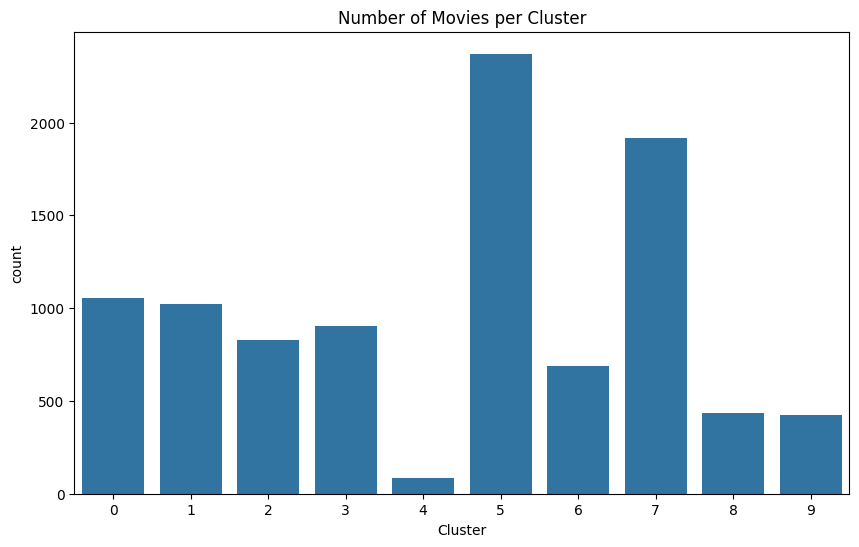

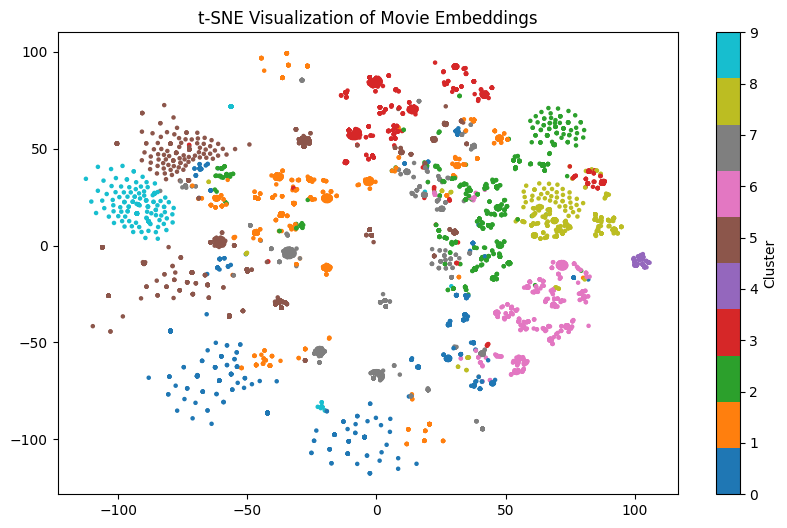

In [9]:
# Cluster distribution
plt.figure(figsize=(10,6))
sns.countplot(x='Cluster', data=df_features)
plt.title("Number of Movies per Cluster")
plt.show()

# t-SNE visualization of embeddings
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_embeddings)
plt.figure(figsize=(10,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='tab10', s=5)
plt.colorbar(label='Cluster')
plt.title("t-SNE Visualization of Movie Embeddings")
plt.show()



### **Project Flow**
* **Load Dataset:** `movies.csv` (title, genres) and `ratings.csv` (user ratings).
* **Preprocess Data:**
  * One-hot encode genres (e.g., `Comedy|Action` → `[Comedy=1, Action=1]`).
  * Optionally normalize ratings.
* **Autoencoder & Embeddings:**
  * Compress high-dimensional movie features into **dense embeddings**.
  * Capture **non-linear relationships** between genres and features.
* **Similarity Calculation:**
  * Use **cosine similarity** on embeddings to find similar movies.
* **Clustering (Optional):**
  * Apply **K-Means** to group similar movies for cluster-based recommendations.
* **Recommendation:**
  * Recommend **top-N nearest neighbors** for a given movie.
* **Visualization (Optional):**
  * Use **t-SNE / UMAP** to visualize clusters of movies in 2D space.
